In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy.linalg as npl
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (6,4)

In [140]:
# Dataset 1

In [142]:
excel_file=pd.ExcelFile('hyrdodata.xlsx')
df=pd.read_excel(excel_file, sheet_name="figure 2_unit_hydrograph")

In [143]:
L = 10
phi = 0.4
C = 1.2183396582162898
D = 1.1709401241247828

In [146]:
t = df["Time"][:371].values*3600
avgstart = df["peakAvg_start"][:371].values*1000

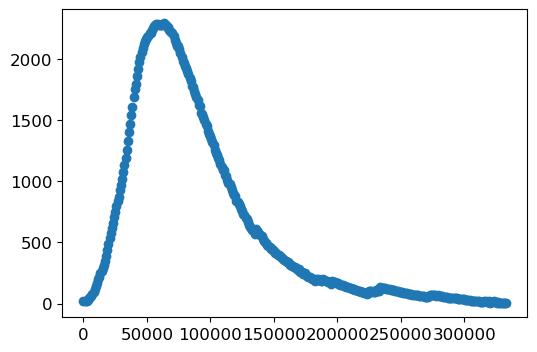

In [148]:
plt.scatter(t,avgstart)

In [150]:
tmax = 65
train = t[:tmax]
tdrought = t[tmax-1:]

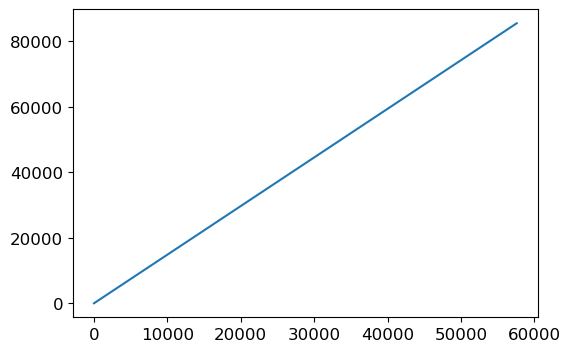

In [152]:
def fluxrain(C,train,p1):
    return C**2/2*p1*train
plt.plot(train,fluxrain(C,train,2))

In [154]:
def thetafind(D,C,p1,p2,tendofrain):
    return np.sqrt(D**2/C**2*p2/(p1*tendofrain))-tendofrain
print(thetafind(D,C,2,4,train[-1]))

-57599.99433669355


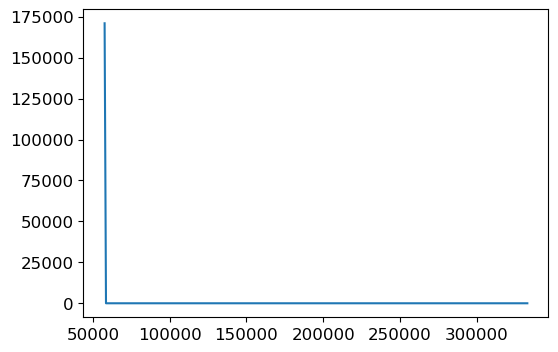

In [156]:
def fluxdrought(D,train,tdrought,p2,p1):
    theta =thetafind(D,C,p1,p2,train[-1])
    return D**2/2*p2*1/(tdrought+theta)**2
plt.plot(tdrought,fluxdrought(D,train,tdrought,2,4))

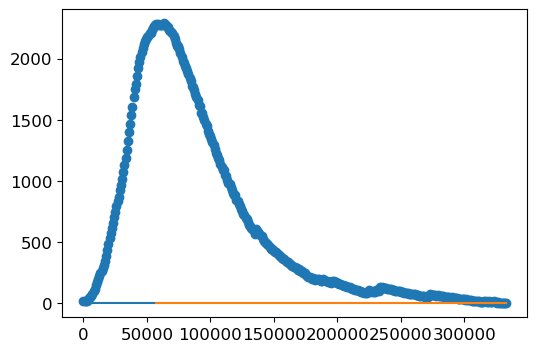

In [158]:
p1 = 10**-7
p2 = 10**8
### guesses 
### p1 = between 10**-7 10**-8
### p2 = 10**8
plt.plot(train,fluxrain(C,train,p1))
plt.plot(tdrought,fluxdrought(D,train,tdrought,p2,p1))
plt.scatter(t,avgstart)

0 55099.54519803545
1 17530.59497154408
2 34473.251282903366
3 79241.29321002611
4 124009.33513714894
5 168777.37706427168
6 213545.41899139443
7 258313.46091851735
8 303081.50284564
9 347849.5447727628


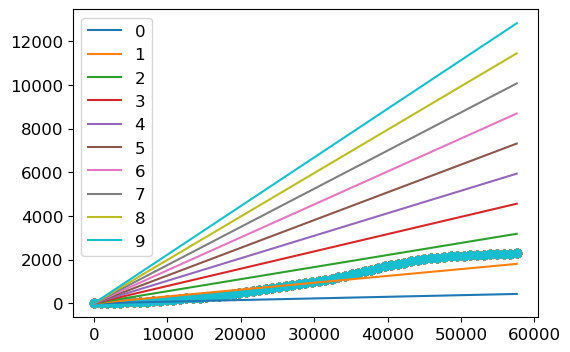

In [160]:
p1 = np.linspace(0.01,0.3,10)
it = 0 
for p1 in p1:
    Qrain = fluxrain(C,train,p1)
    plt.plot(train, Qrain,label = "%.0f"%it)
    plt.scatter(t[:65],avgstart[:65])
    plt.legend()
    i=0
    L2norm = 0
    while(i<65):
        L2norm += np.abs(Qrain[i]-avgstart[i])
        i+=1
    print(it, L2norm)
    it +=1

0 163573.00432092362
1 163573.0033135879
2 163573.00230689926
3 163573.00130041677
4 163573.00029435643


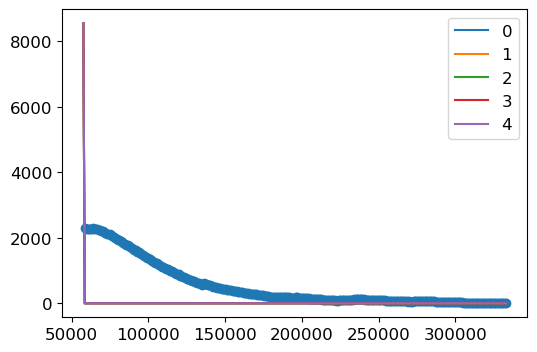

In [161]:
n = 5
#p1 = np.linspace(1,6,n)
p1 = 0.2
p2 = np.linspace(100,3000,n)
j=0
while(j<n):
    Qdrought = fluxdrought(D,train,tdrought,p2[j],p1)
    i = 65
    L2norm = 0
    while(i<371):
        L2norm += np.abs(Qdrought[i-65]-avgstart[i])
        i+=1
    plt.plot(tdrought,Qdrought,label = "%.0f"%j)
    print(j,L2norm)
    j+=1
plt.scatter(t[65:],avgstart[65:])
plt.legend()

In [164]:
tmax = 65
train = t[:tmax]
tdrought = t[tmax:]
def L2norm(params, train, tdrought):
    p1 = params[0]
    p2 = params[1]
    Qrain = fluxrain(C,train,p1)
    Qdrought = fluxdrought(D,train,tdrought,p2,p1)
    Qtest = np.concatenate((Qrain,Qdrought))
    L2norm = npl.norm(Qtest-avgstart)
    return L2norm
#L2norm([0.1,100],train,tdrought)

In [176]:
initial_param = [10**-1,10**1] 
result = minimize(L2norm, initial_param, args=(train,tdrought),method= 'BFGS')
p1 = result.x[0]
p2 = result.x[1]
print(p1,p2)

ValueError: operands could not be broadcast together with shapes (372,) (284,) 

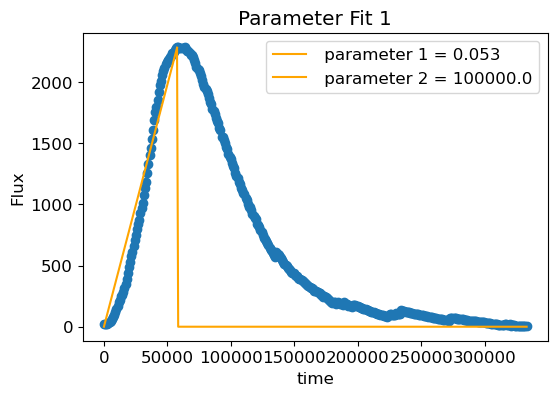

In [168]:
tmax = 65
train = t[:tmax]
tdrought = t[tmax-1:]
plt.plot(train,fluxrain(C,train,p1),color = 'orange',label = " parameter 1 = %.3f"%p1)
plt.plot(tdrought,fluxdrought(D,train,tdrought,p2,p1),color = 'orange', label = " parameter 2 = %.1f"%p2 )
plt.scatter(t,avgstart)
plt.legend()
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Parameter Fit 1')
plt.savefig('Parameter Fit 1')

In [170]:
t = df["Time"][486:770].values
avgstart = df["peakAvg_start"][486:770].values
#plt.scatter(t,avgstart)
#print(avgstart[38])

0.26137077554822497 322.8549112510301


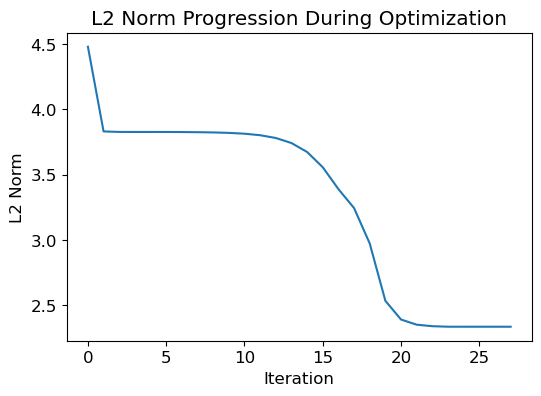

In [130]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define initial parameters
tmax = 38
train = t[:tmax]
tdrought = t[tmax:]
initial_param = [.1, 1200]

# Function to calculate L2 norm
def L2norm(params, train, tdrought):
    p1 = params[0]
    p2 = params[1]
    Qrain = fluxrain(C, train, p1)
    Qdrought = fluxdrought(D, train, tdrought, p2, p1)
    Qtest = np.concatenate((Qrain, Qdrought))
    L2norm = np.linalg.norm(Qtest - avgstart)
    return L2norm

# List to store values at each iteration for plotting
iteration_values = []

# Define a callback function to capture parameter and loss values at each iteration
def store_iteration_values(xk):
    # Here, store the current parameter values (xk) and L2 norm value
    iteration_values.append(L2norm(xk, train, tdrought))

# Perform optimization with callback to store each iteration's L2 norm
result = minimize(L2norm, initial_param, args=(train, tdrought), method='BFGS', callback=store_iteration_values)

# Extract the optimized parameters
p1 = result.x[0]
p2 = result.x[1]

# Print the optimized parameters
print(p1, p2)

# Plot the iteration progress
plt.plot(iteration_values)
plt.xlabel('Iteration')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Progression During Optimization')
plt.show()

In [1140]:
tmax = 38
train = t[:tmax]
tdrought = t[tmax:]
def L2norm(params, train, tdrought):
    p1 = params[0]
    p2 = params[1]
    Qrain = fluxrain(C,train,p1)
    Qdrought = fluxdrought(D,train,tdrought,p2,p1)
    Qtest = np.concatenate((Qrain,Qdrought))
    L2norm = npl.norm(Qtest-avgstart)
    #print(L2norm)
    #print(p1)
    #print(p2)
    #print("\n")
    return L2norm

In [1142]:
initial_param = [0.01,1400] 
#option = {'maxiter': 5}
result = minimize(L2norm, initial_param, args=(train,tdrought), method= 'BFGS')#, options=option)
p1 = result.x[0]
p2 = result.x[1]
#print(p1,p2)

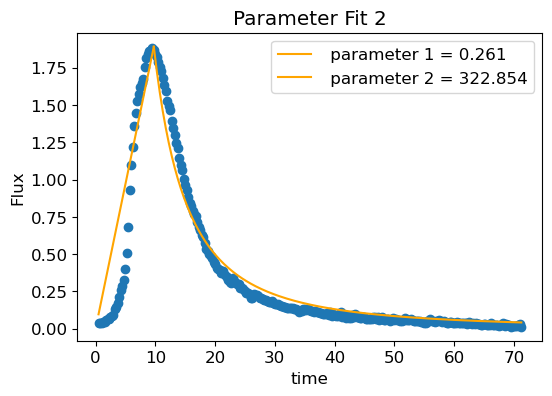

In [1144]:
tmax = 38
train = t[:tmax]
tdrought = t[tmax-1:]
plt.plot(train,fluxrain(C,train,p1),color = 'orange',label = " parameter 1 = %.3f"%p1)
plt.plot(tdrought,fluxdrought(D,train,tdrought,p2,p1),color = 'orange',label = " parameter 2 = %.3f"%p2)
plt.scatter(t,avgstart)
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Parameter Fit 2')
plt.legend()
#plt.savefig('Parameter Fit 2')

In [1026]:
t = df["Time"][784:1100].values
avgstart = df["peakAvg_start"][784:1100].values
#print(avgstart[120])

In [1028]:
tmax = 120
train = t[:tmax]
tdrought = t[tmax:]
def L2norm(params, train, tdrought):
    p1 = params[0]
    p2 = params[1]
    Qrain = fluxrain(C,train,p1)
    Qdrought = fluxdrought(D,train,tdrought,p2,p1)
    Qtest = np.concatenate((Qrain,Qdrought))
    L2norm = npl.norm(Qtest-avgstart)
    return L2norm

In [1030]:
initial_param = [0.01,1100] 
result = minimize(L2norm, initial_param, args=(train,tdrought), method= 'BFGS')
p1 = result.x[0]
p2 = result.x[1]
print(p1,p2)

0.06661417191684726 2072.3179660794253


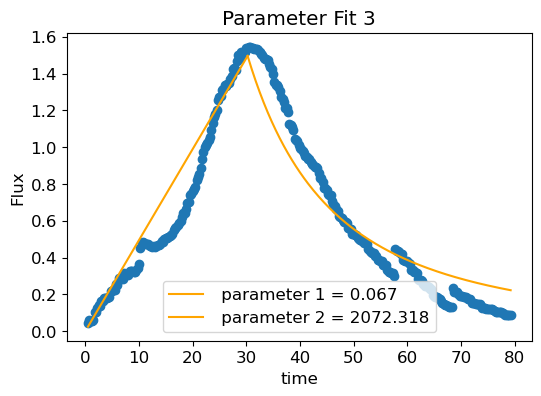

In [1032]:
tmax = 120
train = t[:tmax]
tdrought = t[tmax-1:]
plt.plot(train,fluxrain(C,train,p1),color = 'orange',label = " parameter 1 = %.3f"%p1)
plt.plot(tdrought,fluxdrought(D,train,tdrought,p2,p1),color = 'orange',label = " parameter 2 = %.3f"%p2)
plt.scatter(t,avgstart)
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Parameter Fit 3')
plt.savefig('Parameter Fit 3')
plt.legend()

43
0.579859483735833


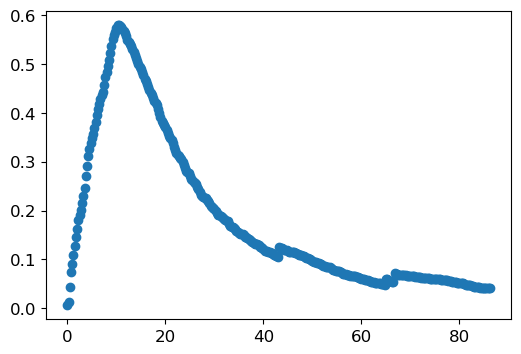

In [1062]:
t = df["Time"][1124:1470].values
print(1167-1124)
avgstart = df["peakAvg_start"][1124:1470].values
plt.scatter(t,avgstart)
print(avgstart[41])

In [1064]:
tmax = 43
train = t[:tmax]
tdrought = t[tmax:]
def L2norm(params, train, tdrought):
    p1 = params[0]
    p2 = params[1]
    Qrain = fluxrain(C,train,p1)
    Qdrought = fluxdrought(D,train,tdrought,p2,p1)
    Qtest = np.concatenate((Qrain,Qdrought))
    L2norm = npl.norm(Qtest-avgstart)
    return L2norm

In [1066]:
initial_param = [0.01,1100] 
result = minimize(L2norm, initial_param, args=(train,tdrought), method= 'BFGS')
p1 = result.x[0]
p2 = result.x[1]
print(p1,p2)

0.08360049191381504 611.0910055508263


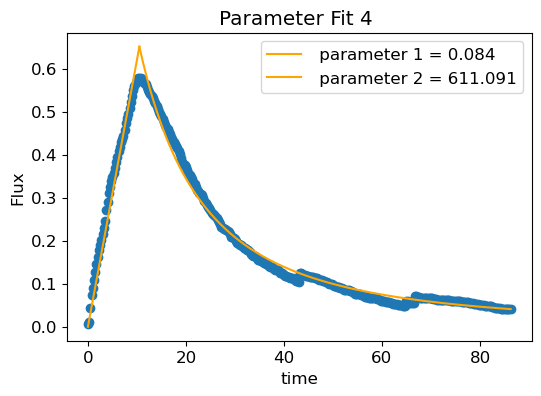

In [1068]:
tmax = 43
train = t[:tmax]
tdrought = t[tmax-1:]
plt.plot(train,fluxrain(C,train,p1),color = 'orange',label = " parameter 1 = %.3f"%p1)
plt.plot(tdrought,fluxdrought(D,train,tdrought,p2,p1),color = 'orange',label = " parameter 2 = %.3f"%p2)
plt.scatter(t,avgstart)
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Parameter Fit 4 ')
plt.savefig('Parameter Fit 4')
plt.legend()